In [1]:
from os import listdir
from os.path import isfile,join
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from scipy.sparse import hstack
import tensorflow as tf
from keras.layers import Dense
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output
import re
%matplotlib inline

Using TensorFlow backend.


#Preprocession the data

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/zero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE," ",text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE,"",text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split() if word not in STOPWORDS])# delete stopwords from text
    return text

In [4]:
def get_files(path:str):
    pos_path=path+"/pos/"
    neg_path=path+"/neg/"
    pos_files = [ file for file in listdir(pos_path) if isfile(join(pos_path,file))]
    neg_files=[ file for file in listdir(neg_path) if isfile(join(neg_path,file))]
    return [pos_files,neg_files]

In [5]:
def label_preprocessing(label):
    return int(round(float(label)/10.0))

In [6]:

def get_texts(path,pos_files,neg_files):
    texts=[]
    pos_path=path+"/pos/"
    neg_path=path+"/neg/"
    for i in pos_files:
        with open(pos_path+i,"r") as fin:
            text=fin.read()
            fin.close()
        filename=os.path.splitext(i)[0]
        label=filename.split("_")[1]
        texts.append([label_preprocessing(label),text_prepare(text)])
    for i in neg_files:
        with open(neg_path+i,"r") as fin:
            text=fin.read()
            fin.close()
        filename=os.path.splitext(i)[0]
        label=filename.split("_")[1]
        texts.append([label_preprocessing(label),text_prepare(text)])
    texts=np.array(texts)
    return texts

In [47]:
def save_data(file:str,texts,features):
    labels=[[float(text[0])] for text in texts]
    labels=np.array(labels)
    features=hstack((labels,features))

    pd.DataFrame(
        features.todense(),
        columns=['label']+tfidf.get_feature_names()
    ).to_csv(file)

In [8]:
train_path=os.getcwd()+"/aclImdb/train/"
train_pos_files,train_neg_files=get_files(train_path)

In [9]:
train_texts=get_texts(train_path,train_pos_files,train_neg_files)

In [10]:
print(train_texts[0])

['1'
 'cosimo luis guzman ends prison car burglary hes given plan perfect heist lifer prison get jail fast tells girlfriend rosalind patricia clarkson find man time prison money one wants time cosimos crime yet everybody seems know guy soon bad boxer pero mahalovic sam rockwell founds details called perfect jobbr br first think movie funny point view would recommend everyone movie remake italian comedy soliti ignoti didnt watch italian original cannot judge compare two movies welcome collinwood great comedy four people trying rob money vault one house everyone gave part brilliance movie cast really excellent movie actors sam rockwell william h macy great isaiah washington michael jeter great luis guzmn patricia clarkson jennifer esposito finally george clooney gave share project br br maybe say movie comedy isnt fair one difference thieves movie small wishes asked money mostly securing future humble way fact goes beyond comedy soul criminals also cop babitch presented like corrupted on

In [11]:
np.random.shuffle(train_texts)

In [12]:
labels=[train_text[0] for train_text in train_texts]
print(labels[0:10])

['1', '0', '0', '0', '0', '0', '0', '0', '1', '0']


In [13]:
tfidf=TfidfVectorizer(ngram_range=(1,5),max_df=0.9,min_df=0.0008)

In [14]:
train_features=tfidf.fit_transform(train_texts[:,1])

In [15]:
print(len(tfidf.get_feature_names()))
print(train_features.shape)

21787
(25000, 21787)


In [16]:
train_features.get_shape()

(25000, 21787)

In [17]:
test_path=os.getcwd()+"/aclImdb/test/"
test_pos_files,test_neg_files=get_files(test_path)
test_texts=get_texts(test_path,test_pos_files,test_neg_files)
np.random.shuffle(test_texts)

In [18]:
test_labels=[int(test_text[0]) for test_text in test_texts]

In [19]:
test_features=tfidf.transform(test_texts[:,1])

#Train the data

In [20]:
input_num=train_features.get_shape()[1]

In [21]:
config=tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction=0.2
tf.reset_default_graph()
sess=tf.InteractiveSession(config=config)
sess.as_default()

In [26]:
with tf.device('/device:GPU:0'):
    X=tf.placeholder(shape=(None,input_num),dtype=tf.float32)
    y=tf.placeholder(shape=(None),dtype=tf.float32)
    network=keras.models.Sequential()
    network.add(Dense(512,activation=tf.nn.relu,input_shape=[input_num]))
    network.add(Dense(256,activation=tf.nn.relu))
    network.add(Dense(128,activation=tf.nn.relu))
    network.add(Dense(64,activation=tf.nn.relu))
    network.add(Dense(1,activation=tf.nn.sigmoid))
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    network.compile(loss='mean_squared_error', optimizer=sgd)

In [27]:
sess.run(tf.global_variables_initializer())

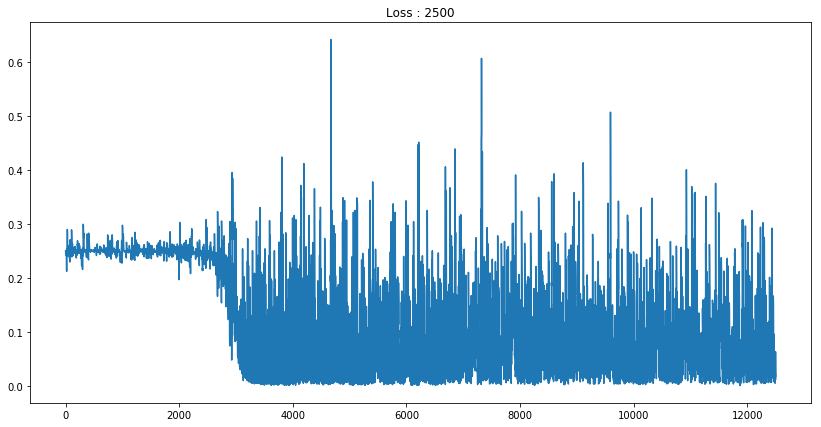

In [28]:

max_iter=5
losses=[]


num=train_features.get_shape()[0]
times=int(num/10.0+1)
for i in range(times):
    s=i*10
    e=min(num,(i+1)*10)
    train_X=np.array(train_features[s:e].todense())
    train_y=np.array(labels[s:e])

    for j in range(max_iter):
        l=network.train_on_batch(train_X,train_y)
        
        losses.append(l)
        if j%100==0:
          clear_output(True)
          plt.figure(figsize=[14, 7])
          plt.title("Loss : "+str(i))
          plt.plot(losses)
          plt.show()
    

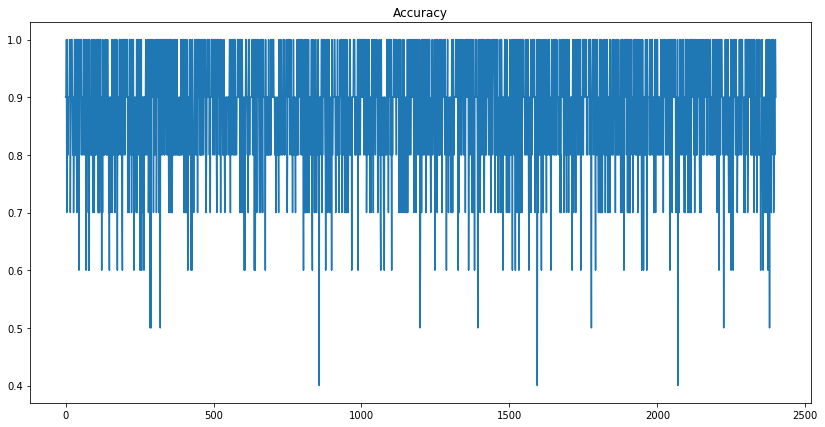

In [68]:
ACCURACY=[]
num=test_features.get_shape()[0]
times=int(num/10.0+1)
predicted=[]
for i in range(times):
    s=i*10
    e=min(num,(i+1)*10)
    if(s==e):
        break;
    test_X=np.array(test_features[s:e].todense())
    test_y=np.array(test_labels[s:e])
    y=network.predict(test_X)
    y=np.array(y)
    y=y.reshape([-1])
    predicted=np.concatenate((predicted,y))
    y=np.round(y)
    accuracy=np.equal(y,test_y)
    accuracy=np.count_nonzero(accuracy)/float(len(y))
    ACCURACY.append(accuracy)
    if(i%100==0):
        clear_output(True)
        plt.figure(figsize=[14, 7])
        plt.title("Accuracy")
        plt.plot(ACCURACY)
        plt.show()

In [37]:
print(sum(ACCURACY)/len(ACCURACY))

0.8780800000000117


In [ ]:
save_data("./train_data.csv",train_texts,train_features)

In [48]:
save_data("./test_data.csv",test_texts,test_features)

KeyboardInterrupt: 

In [49]:
saver=tf.train.Saver()
saver.save(sess,"sentiment_model.ckpy",global_step=0)

'sentiment_model.ckpy-0'

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [51]:

def print_evaluation_scores(y_val, predicted):
    print ("Accracy={}".format(accuracy_score(y_val, predicted)), 
        "F1_macro={}".format(f1_score(y_val, predicted, average='macro')),
        "F1_micro={}".format(f1_score(y_val, predicted, average='micro')),
        "F1_wted={}".format(f1_score(y_val, predicted, average='weighted')),
        "Precsion_macro={}".format(average_precision_score(y_val, predicted, average='macro')),
        "Precsion_micro={}".format(average_precision_score(y_val, predicted, average='micro')),
        "Precsion_wted={}".format(average_precision_score(y_val, predicted, average='weighted')))

In [52]:
print_evaluation_scores(test_labels,predicted)

Accracy=0.87808 F1_macro=0.878077375054654 F1_micro=0.87808 F1_wted=0.878077375054654 Precsion_macro=0.8333234366925065 Precsion_micro=0.8333234366925065 Precsion_wted=0.8333234366925065


In [81]:
from sklearn.metrics import roc_curve,auc
def roc_accuracy(y,predicted,n_classes):
    color=["aqua","blue","coral","cyan","gold"]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i],tpr[i],color=color[i],lw=2,label="ROC curve class %d (area = %0.2f)"%(i,roc_auc[i]))
    plt.plot(fpr['micro'],tpr['micro'],color=color[n_classes+1],lw=2,label="ROC curve micro (area = %0.2f)"%(roc_auc['micro']))
    
    plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


In [71]:
y=[]
predicted_y=[]

for i in range(len(predicted)):
    predicted_y.append([1-predicted[i],predicted[i]])
    
    y.append([1-test_labels[i],test_labels[i]])
    
y=np.array(y)
predicted_y=np.array(predicted_y)

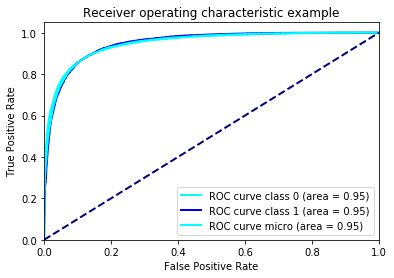

In [82]:



roc_accuracy(y,predicted_y,2)

In [72]:
print((predicted_y))

[[0.96082178 0.03917822]
 [0.23621923 0.76378077]
 [0.9394027  0.0605973 ]
 ...
 [0.08658063 0.91341937]
 [0.96846072 0.03153928]
 [0.19361168 0.80638832]]
